In [2]:
import pickle
import numpy as np
import pomegranate as pom
import sys
sys.path.append('../src')
from visualization import draw_timeline_with_merged_states, save_png, draw_distribution

from variables import toys_dict, tasks, toys_list
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils import check_random_state


import pandas as pd
from pathlib import Path
import os 
import importlib
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt

13


In [69]:
state_name_dict = OrderedDict({4: "No_toys", 2: "F+", 0: "F", 3: "E", 1:"E+"})
n_states = 5

toy_colors_dict = {'bricks': 'blue', 'pig': 'orange', 'popuppals': 'green', 'xylophone': 'red', 'shape_sorter': 'skyblue',
                   'shape_sorter_blocks': 'salmon', 'broom': 'purple', 'clear_ball': 'teal', 'balls': 'cadetblue',
                   'food': 'chocolate', 'grocery_cart': 'dodgerblue', 'stroller': 'violet', 'bucket': 'navy'}

interval_length = 1.5
shift_time_list = np.arange(0, interval_length, .25)
with open('../data/interim/20210721_5_states_merged_prediction_'+str(interval_length)+'_min.pickle', 'rb') as f:
    merged_pred_dict_all = pickle.load(f)

with open('../data/interim/20210721_5_states_merged_prediction_prob_'+str(interval_length)+'_min.pickle', 'rb') as f:
    merged_proba_dict_all = pickle.load(f)

with open('../data/interim/20210721_5_states_time_arr_dict_'+str(interval_length)+'_min.pickle', 'rb') as f:
    time_subj_dict_all = pickle.load(f)

with open('../data/interim/20210721_clean_data_for_feature_engineering.pickle', 'rb') as f:
    task_to_storing_dict = pickle.load(f)

In [5]:
def merge_toy_pred(pred_df, subj_df):
    toys = []

    all_onsets = list(set(pred_df['onset'].unique().tolist() + subj_df['onset'].unique().tolist()))
    # print(all_onsets)
    all_offsets = list(set(pred_df['offset'].unique().tolist() + subj_df['offset'].unique().tolist()))
    # print(len(all_onsets) - len(all_offsets))
    time = list(set(all_onsets + all_offsets))
    time.sort()
    toys_list = []
    pred_list = []
    onset_list = []
    offset_list = []
    for idx, onset in enumerate(time):
        if idx != len(time) - 1:
            offset = time[idx+1] 
            onset_list.append(onset)
            offset_list.append(offset)

            pred = pred_df.loc[(pred_df.loc[:,'onset'] <= onset) & (pred_df.loc[:,'offset'] >= offset), 'pred'].tolist()
            pred_list.append(pred[0])
            toys = subj_df.loc[(subj_df.loc[:,'onset'] <= onset) & (subj_df.loc[:,'offset'] >= offset), 'toy'].tolist()
            if 'no_ops' in toys:
                toys = [t for t in toys if 'no_ops' not in t]
            toys_list.append(list(set(itertools.chain.from_iterable(toys))))
            # else:
            #     toys_list.append(['no_ops'])



    # for idx, row in enumerate(pred_df.itertuples()):
    #     toy_list = subj_df.loc[(subj_df.loc[:,'onset'] <= row.onset) & (subj_df.loc[:,'offset'] >= row.offset) & (subj_df.loc[:,'toy'] != 'no_ops'), 'toy'].tolist()
        # toys.append(list(set(itertools.chain.from_iterable(toy_list))))
    # pred_df['toy'] = toys
    return pd.DataFrame({'onset': onset_list, 'offset': offset_list, 'pred': pred_list, 'toys':toys_list })

In [6]:
subj_list = list(task_to_storing_dict['MPS'].keys())

toy_pred_list = {}
    
for task in tasks:
    toy_pred_list[task] = {}
    for subj in subj_list:
        subj_df = pd.DataFrame()
        pred = []
        onset = []
        offset = []

        onset.append(time_subj_dict_all[task][subj][0] - shift_time_list[1]*60000)
        onset.extend(time_subj_dict_all[task][subj][:-1]) 
        offset.extend(time_subj_dict_all[task][subj])
        pred.extend(merged_pred_dict_all[task][subj])

        for df_ in task_to_storing_dict[task][subj]:
            subj_df = pd.concat([subj_df, df_])
        pred_df = pd.DataFrame(data = {'onset': onset, 'offset': offset, 'pred': pred})

        pred_df = merge_toy_pred(pred_df, subj_df)
        toy_pred_list[task][subj] = pred_df

In [24]:
stationary_df = pd.DataFrame()
for task in ['MPS', "NMS"]:
    for subj in subj_list:
        stationary_df = pd.concat([stationary_df,  toy_pred_list[task][subj]])



mobile_df = pd.DataFrame()
for task in ['MPM', "NMM"]:
    for subj in subj_list:
        mobile_df = pd.concat([mobile_df,  toy_pred_list[task][subj]])

nmm_df = pd.DataFrame()
for subj in subj_list:
    nmm_df = pd.concat([nmm_df, toy_pred_list["NMM"][subj]])

nms_df = pd.DataFrame()
for subj in subj_list:
    nms_df = pd.concat([nms_df, toy_pred_list["NMS"][subj]])

mps_df = pd.DataFrame()
for subj in subj_list:
    mps_df = pd.concat([mps_df, toy_pred_list["MPS"][subj]])

mpm_df = pd.DataFrame()
for subj in subj_list:
    mpm_df = pd.concat([mpm_df, toy_pred_list["MPM"][subj]])

In [34]:
stationary_df = stationary_df.explode('toys') 
stationary_df['duration'] = stationary_df['offset'] - stationary_df['onset'] 
stationary_df['pred'] = stationary_df['pred'].replace(state_name_dict)

stationary_toy_to_pred_dict = (stationary_df.groupby(['pred', 'toys'])['duration'].sum()/stationary_df.groupby(['pred'])['duration'].sum()).to_dict()


In [33]:
stationary_toy_to_pred_dict

{('E', 'bricks'): 0.03999666866546739,
 ('E', 'pig'): 0.03659204477313612,
 ('E', 'popuppals'): 0.061521087347591444,
 ('E', 'shape_sorter'): 0.36480178559530946,
 ('E', 'shape_sorter_blocks'): 0.42601905523352657,
 ('E', 'xylophone'): 0.0225124925044973,
 ('E+', 'bricks'): 0.06664632516957038,
 ('E+', 'pig'): 0.11439931622247028,
 ('E+', 'popuppals'): 0.10314664640097639,
 ('E+', 'shape_sorter'): 0.20356443674584057,
 ('E+', 'shape_sorter_blocks'): 0.17701044428482898,
 ('E+', 'xylophone'): 0.07856164136929862,
 ('F', 'bricks'): 0.08142197878271583,
 ('F', 'pig'): 0.03814762552858144,
 ('F', 'popuppals'): 0.15495715361446097,
 ('F', 'shape_sorter'): 0.12757108102411163,
 ('F', 'shape_sorter_blocks'): 0.10454195061357194,
 ('F', 'xylophone'): 0.1006538713952034,
 ('F+', 'bricks'): 0.025714646255037173,
 ('F+', 'pig'): 0.010619012315045565,
 ('F+', 'popuppals'): 0.23833665206965435,
 ('F+', 'shape_sorter'): 0.32957308207806285,
 ('F+', 'shape_sorter_blocks'): 0.32547732902814974,
 ('F+'

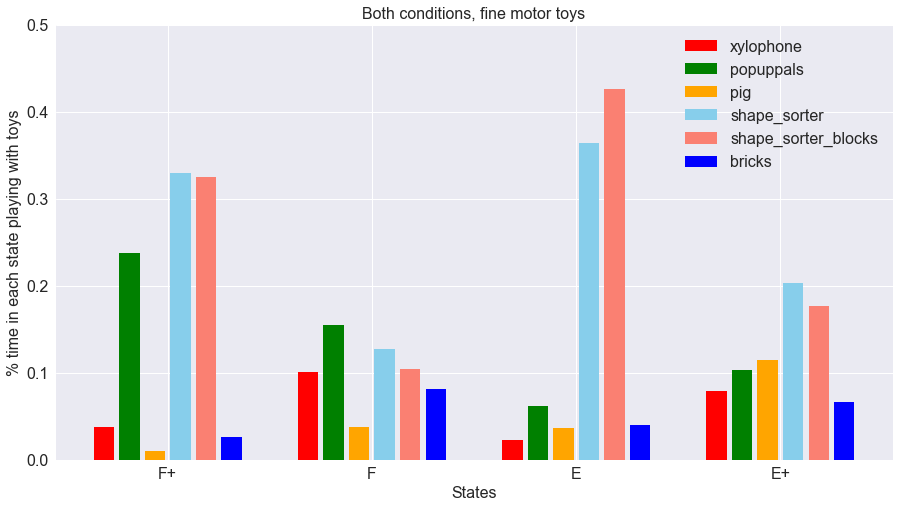

In [75]:
stationary_toy_list = stationary_df['toys'].dropna().unique()
# stationary_toy_list = np.unique(stationary_toy_list[~np.isnan(stationary_toy_list)])
plt.style.use("seaborn")
fig = plt.figure(figsize= (15,8))
for x_loc, state in enumerate(state_name_dict.values()):
    if state != "No_toys":
        current_state_dict_stationary_toy = {k: stationary_toy_to_pred_dict[k] for k in stationary_toy_to_pred_dict.keys() if state in k}
        for idx, toy in enumerate(stationary_toy_list):
            key = (state, toy)
            if x_loc == 1:
                plt.bar(x_loc*8 + idx, current_state_dict_stationary_toy[key], label = toy, color = toy_colors_dict[toy])
            else:
                plt.bar(x_loc*8 + idx, current_state_dict_stationary_toy[key], color = toy_colors_dict[toy])
plt.xticks([10.5, 18.5, 26.5, 34.5], ['F+', 'F', 'E', 'E+'], fontsize = 16)
plt.ylabel("% time in each state playing with toys", fontsize = 16)

plt.xlabel('States', fontsize = 16)
plt.ylim(top = 0.5)
plt.yticks(fontsize = 16)
plt.title("Both conditions, fine motor toys", fontsize = 16)

plt.legend(fontsize = 16)
plt.show()

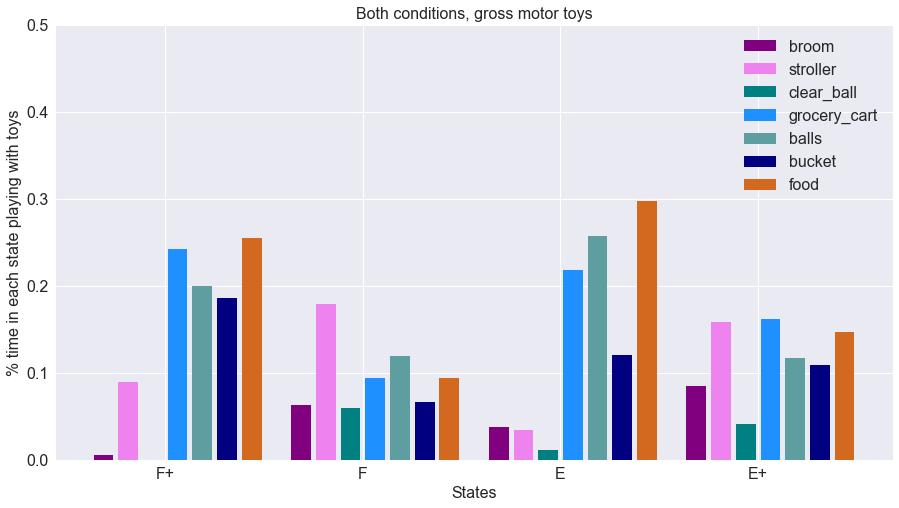

In [76]:
mobile_df = mobile_df.explode('toys') 
mobile_df['duration'] = mobile_df['offset'] - mobile_df['onset'] 
mobile_df['pred'] = mobile_df['pred'].replace(state_name_dict)

mobile_toy_to_pred_dict = (mobile_df.groupby(['pred', 'toys'])['duration'].sum()/mobile_df.groupby(['pred'])['duration'].sum()).to_dict()

mobile_toy_list = mobile_df['toys'].dropna().unique()
# stationary_toy_list = np.unique(stationary_toy_list[~np.isnan(stationary_toy_list)])
plt.style.use("seaborn")
fig = plt.figure(figsize= (15,8))
for x_loc, state in enumerate(state_name_dict.values()):
    if state != "No_toys":
        current_state_dict_mobile_toy = {k: mobile_toy_to_pred_dict[k] for k in mobile_toy_to_pred_dict.keys() if state in k}
        for idx, toy in enumerate(mobile_toy_list):
            key = (state, toy)
            if key not in mobile_toy_to_pred_dict.keys():
                val = 0
            else:
                val = current_state_dict_mobile_toy[key]
            if x_loc == 1:
                plt.bar(x_loc*8 + idx, val, label = toy, color = toy_colors_dict[toy])
            else:
                plt.bar(x_loc*8 + idx, val, color = toy_colors_dict[toy])
plt.xticks([10.5, 18.5, 26.5, 34.5], ['F+', 'F', 'E', 'E+'], fontsize = 16)
plt.ylabel("% time in each state playing with toys", fontsize = 16)
plt.ylim(top = 0.5)

plt.xlabel('States', fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("Both conditions, gross motor toys", fontsize = 16)

plt.legend(fontsize = 16)
plt.show()

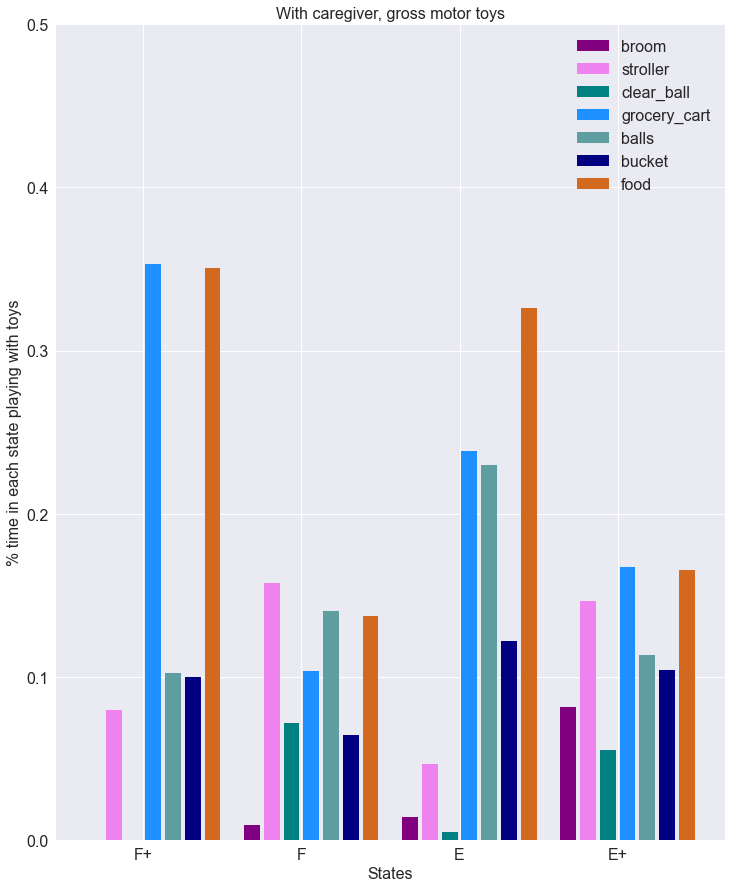

In [91]:
mpm_df = mpm_df.explode('toys') 
mpm_df['duration'] = mpm_df['offset'] - mpm_df['onset'] 
mpm_df['pred'] = mpm_df['pred'].replace(state_name_dict)

mpm_toy_to_pred_dict = (mpm_df.groupby(['pred', 'toys'])['duration'].sum()/mpm_df.groupby(['pred'])['duration'].sum()).to_dict()

mpm_toy_list = mpm_df['toys'].dropna().unique()
# stationary_toy_list = np.unique(stationary_toy_list[~np.isnan(stationary_toy_list)])
plt.style.use("seaborn")
fig = plt.figure(figsize= (12,15))
for x_loc, state in enumerate(state_name_dict.values()):
    if state != "No_toys":
        current_state_dict_mpm_toy = {k: mpm_toy_to_pred_dict[k] for k in mpm_toy_to_pred_dict.keys() if state in k}
        for idx, toy in enumerate(mpm_toy_list):
            key = (state, toy)
            if key not in mpm_toy_to_pred_dict.keys():
                val = 0
            else:
                val = current_state_dict_mpm_toy[key]
            if x_loc == 1:
                plt.bar(x_loc*8 + idx, val, label = toy, color = toy_colors_dict[toy])
            else:
                plt.bar(x_loc*8 + idx, val, color = toy_colors_dict[toy])
plt.xticks([10.5, 18.5, 26.5, 34.5], ['F+', 'F', 'E', 'E+'], fontsize = 16)
plt.ylabel("% time in each state playing with toys", fontsize = 16)
plt.ylim(top = 0.5)

plt.xlabel('States', fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("With caregiver, gross motor toys", fontsize = 16)

plt.legend(fontsize = 16)
plt.show()

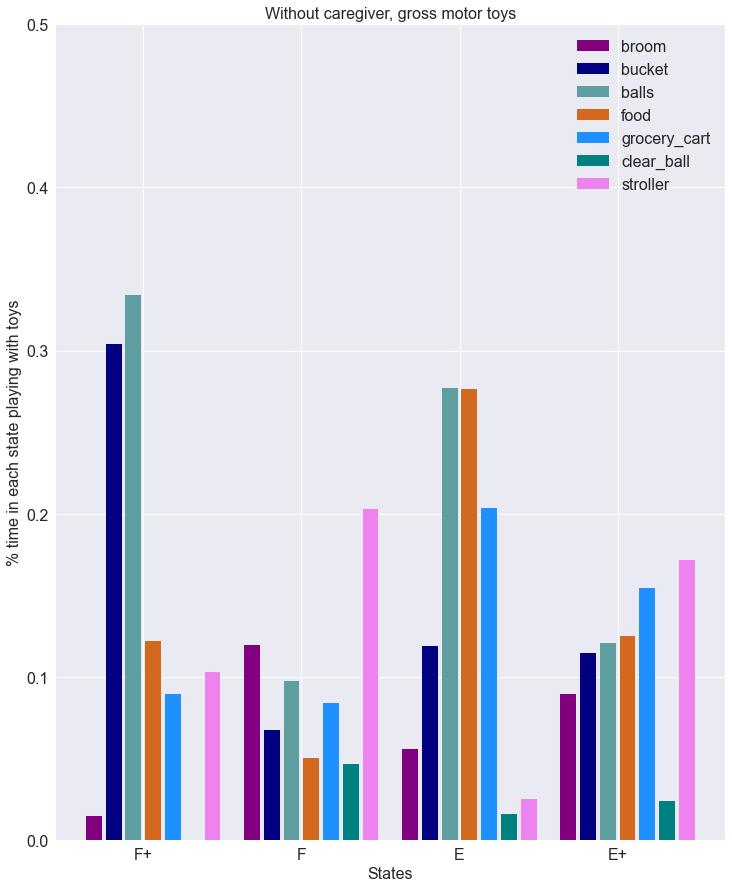

In [90]:
nmm_df = nmm_df.explode('toys') 
nmm_df['duration'] = nmm_df['offset'] - nmm_df['onset'] 
nmm_df['pred'] = nmm_df['pred'].replace(state_name_dict)

nmm_toy_to_pred_dict = (nmm_df.groupby(['pred', 'toys'])['duration'].sum()/nmm_df.groupby(['pred'])['duration'].sum()).to_dict()

nmm_toy_list = nmm_df['toys'].dropna().unique()
# stationary_toy_list = np.unique(stationary_toy_list[~np.isnan(stationary_toy_list)])
plt.style.use("seaborn")
fig = plt.figure(figsize= (12,15))
for x_loc, state in enumerate(state_name_dict.values()):
    if state != "No_toys":
        current_state_dict_nmm_toy = {k: nmm_toy_to_pred_dict[k] for k in nmm_toy_to_pred_dict.keys() if state in k}
        for idx, toy in enumerate(nmm_toy_list):
            key = (state, toy)
            if key not in nmm_toy_to_pred_dict.keys():
                val = 0
            else:
                val = current_state_dict_nmm_toy[key]
            if x_loc == 1:
                plt.bar(x_loc*8 + idx, val, label = toy, color = toy_colors_dict[toy])
            else:
                plt.bar(x_loc*8 + idx, val, color = toy_colors_dict[toy])
plt.xticks([10.5, 18.5, 26.5, 34.5], ['F+', 'F', 'E', 'E+'], fontsize = 16)
plt.ylabel("% time in each state playing with toys", fontsize = 16)

plt.xlabel('States', fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("Without caregiver, gross motor toys", fontsize = 16)
plt.ylim(top = 0.5)

plt.legend(fontsize = 16)
plt.show()

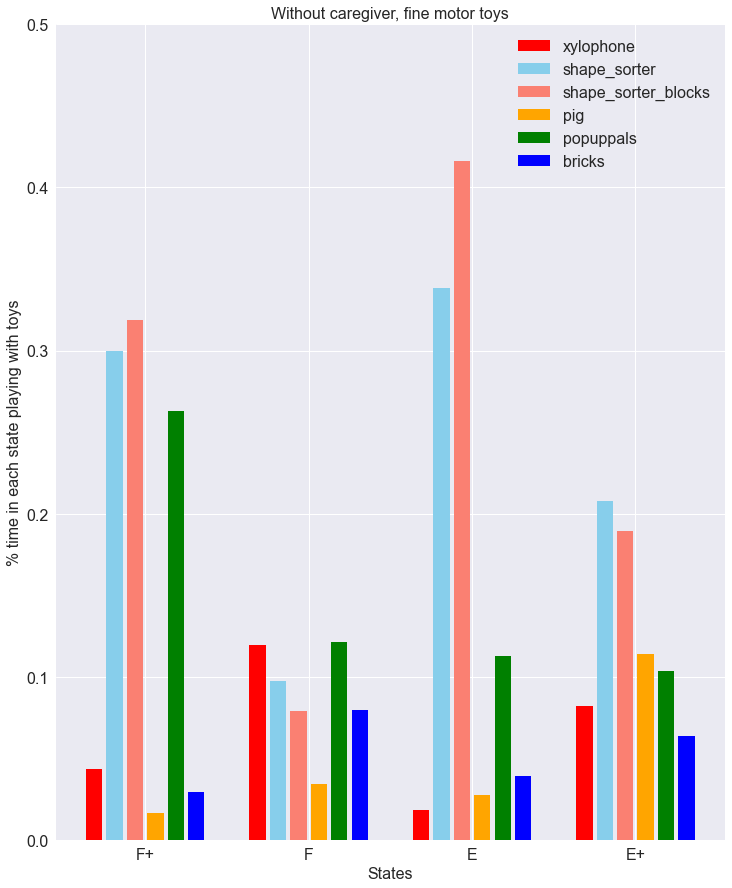

In [89]:
nms_df = nms_df.explode('toys') 
nms_df['duration'] = nms_df['offset'] - nms_df['onset'] 
nms_df['pred'] = nms_df['pred'].replace(state_name_dict)

nms_toy_to_pred_dict = (nms_df.groupby(['pred', 'toys'])['duration'].sum()/nms_df.groupby(['pred'])['duration'].sum()).to_dict()

nms_toy_list = nms_df['toys'].dropna().unique()
# stationary_toy_list = np.unique(stationary_toy_list[~np.isnan(stationary_toy_list)])
plt.style.use("seaborn")
fig = plt.figure(figsize= (12,15))
for x_loc, state in enumerate(state_name_dict.values()):
    if state != "No_toys":
        current_state_dict_nms_toy = {k: nms_toy_to_pred_dict[k] for k in nms_toy_to_pred_dict.keys() if state in k}
        for idx, toy in enumerate(nms_toy_list):
            key = (state, toy)
            if key not in nms_toy_to_pred_dict.keys():
                val = 0
            else:
                val = current_state_dict_nms_toy[key]
            if x_loc == 1:
                plt.bar(x_loc*8 + idx, val, label = toy, color = toy_colors_dict[toy])
            else:
                plt.bar(x_loc*8 + idx, val, color = toy_colors_dict[toy])
plt.xticks([10.5, 18.5, 26.5, 34.5], ['F+', 'F', 'E', 'E+'], fontsize = 16)
plt.ylabel("% time in each state playing with toys", fontsize = 16)

plt.xlabel('States', fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("Without caregiver, fine motor toys", fontsize = 16)
plt.ylim(top = 0.5)

plt.legend(fontsize = 16)
plt.show()

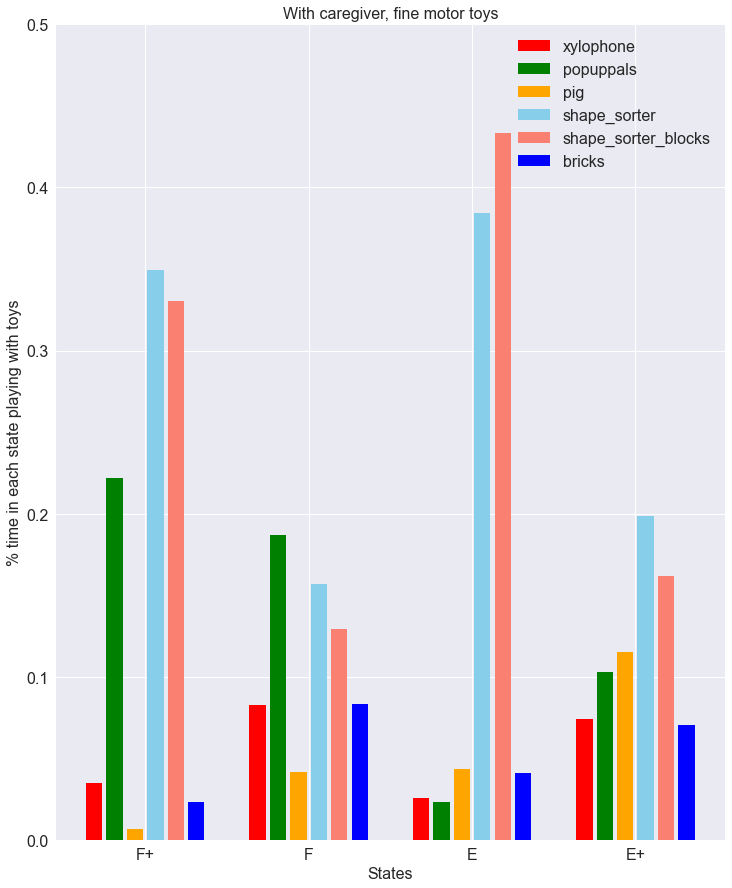

In [87]:
mps_df = mps_df.explode('toys') 
mps_df['duration'] = mps_df['offset'] - mps_df['onset'] 
mps_df['pred'] = mps_df['pred'].replace(state_name_dict)

mps_toy_to_pred_dict = (mps_df.groupby(['pred', 'toys'])['duration'].sum()/mps_df.groupby(['pred'])['duration'].sum()).to_dict()

mps_toy_list = mps_df['toys'].dropna().unique()
# stationary_toy_list = np.unique(stationary_toy_list[~np.isnan(stationary_toy_list)])
plt.style.use("seaborn")
fig = plt.figure(figsize= (12,15))
for x_loc, state in enumerate(state_name_dict.values()):
    if state != "No_toys":
        current_state_dict_mps_toy = {k: mps_toy_to_pred_dict[k] for k in mps_toy_to_pred_dict.keys() if state in k}
        for idx, toy in enumerate(mps_toy_list):
            key = (state, toy)
            if key not in mps_toy_to_pred_dict.keys():
                val = 0
            else:
                val = current_state_dict_mps_toy[key]
            if x_loc == 1:
                plt.bar(x_loc*8 + idx, val, label = toy, color = toy_colors_dict[toy])
            else:
                plt.bar(x_loc*8 + idx, val, color = toy_colors_dict[toy])
plt.xticks([10.5, 18.5, 26.5, 34.5], ['F+', 'F', 'E', 'E+'], fontsize = 16)
plt.ylabel("% time in each state playing with toys", fontsize = 16)

plt.xlabel('States', fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("With caregiver, fine motor toys", fontsize = 16)
plt.ylim(top = 0.5)

plt.legend(fontsize = 16)
plt.show()